# Case 1. Heart Disease
Mr.Pasin Jiratthitcheep<br>
Last edited: xx.xx.2018<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 1. Objectives

classify normal (0) or non-normal (1-4) from labels
mostly avoid non-normal that we predict as normal

use only validation set

## 2. Required libraries

In [1]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## 3. Data description and preprocessing

In [2]:
# r is used to mark as 'raw text' //no interpretaion 
url_pro_cleveland = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
dataframe = pd.read_csv(url_pro_cleveland, 
                        sep = ',', 
                        header = None, 
                        index_col = None,
                        na_values = '?')
# dataframe.sample(10)

In [3]:
dataframe[dataframe.isnull().any(axis=1)]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,NaN,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,NaN,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,NaN,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,NaN,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,NaN,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,NaN,3.0,0


In [4]:
#try replace with median
# dataframe = dataframe.fillna(0)
dataframe = dataframe.dropna()
dataframe = dataframe.reset_index(drop=True)

In [5]:
name_list = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal','num']

dataframe.columns = name_list
# dataframe.tail()

In [6]:
#replace other labels with 1 (unhealthy)
dataframe = dataframe.replace({'num' : { 2 : 1, 3 : 1, 4: 1 }})
# dataframe.tail()

In [7]:
dataframe['num'].value_counts()

0    160
1    137
Name: num, dtype: int64

               age       sex        cp  trestbps      chol       fbs  \
age       1.000000 -0.092399  0.110471  0.290476  0.202644  0.132062   
sex      -0.092399  1.000000  0.008908 -0.066340 -0.198089  0.038850   
cp        0.110471  0.008908  1.000000 -0.036980  0.072088 -0.057663   
trestbps  0.290476 -0.066340 -0.036980  1.000000  0.131536  0.180860   
chol      0.202644 -0.198089  0.072088  0.131536  1.000000  0.012708   
fbs       0.132062  0.038850 -0.057663  0.180860  0.012708  1.000000   
restecg   0.149917  0.033897  0.063905  0.149242  0.165046  0.068831   
thalac   -0.394563 -0.060496 -0.339308 -0.049108 -0.000075 -0.007842   
exang     0.096489  0.143581  0.377525  0.066691  0.059339 -0.000893   
oldpeak   0.197123  0.106567  0.203244  0.191243  0.038596  0.008311   
slope     0.159405  0.033345  0.151079  0.121172 -0.009215  0.047819   
ca        0.362210  0.091925  0.235644  0.097954  0.115945  0.152086   
thal      0.126586  0.383652  0.268500  0.138183  0.010859  0.06

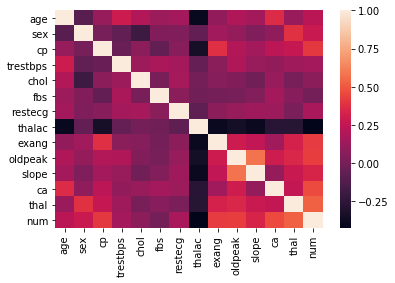

In [8]:
#try to show correlation of each features for selection features
corr = dataframe.corr()
sns.heatmap(corr)
print(corr)

In [9]:
# drop features with correlation in range -0.3 to 0.3
dataframe_corr = dataframe.copy()
dataframe_corr.drop(["age","sex","trestbps","chol","fbs","restecg"],axis=1, inplace=True)

In [10]:
X = dataframe.iloc[:,0:13]
y = dataframe.num

X_corr = dataframe_corr.iloc[:,0:7]
y_corr = dataframe_corr.num

In [11]:
#do one-hot encoding to some features
X = pd.concat([X,pd.get_dummies(X['cp'],prefix='cp')],axis=1)
X = pd.concat([X,pd.get_dummies(X['restecg'],prefix='restecg')],axis=1)
X = pd.concat([X,pd.get_dummies(X['slope'],prefix='slope')],axis=1)
X = pd.concat([X,pd.get_dummies(X['thal'],prefix='thal')],axis=1)

X.drop(['cp','restecg','slope','thal'], axis=1, inplace=True)

# --> for corr set
X_corr = pd.concat([X_corr,pd.get_dummies(X_corr['cp'],prefix='cp')],axis=1)
X_corr = pd.concat([X_corr,pd.get_dummies(X_corr['slope'],prefix='slope')],axis=1)
X_corr = pd.concat([X_corr,pd.get_dummies(X_corr['thal'],prefix='thal')],axis=1)

X_corr.drop(['cp','thal','slope'], axis=1, inplace=True)

In [12]:
X_corr.head()

,thalac,exang,oldpeak,ca,cp_1.0,cp_2.0,cp_3.0,cp_4.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,150.0,0.0,2.3,0.0,1,0,0,0,0,0,1,0,1,0
1,108.0,1.0,1.5,3.0,0,0,0,1,0,1,0,1,0,0
2,129.0,1.0,2.6,2.0,0,0,0,1,0,1,0,0,0,1
3,187.0,0.0,3.5,0.0,0,0,1,0,0,0,1,1,0,0
4,172.0,0.0,1.4,0.0,0,1,0,0,1,0,0,1,0,0


In [13]:
def preprocess_scaler_corr (X_train, X_test):
    X_train_pre_scale = X_train[['thalac','oldpeak','ca']]
    X_train.drop(['thalac','oldpeak','ca'], axis='columns', inplace=True)
    X_train = X_train.reset_index(drop=True)

    X_test_pre_scale = X_test[['thalac','oldpeak','ca']]
    X_test.drop(['thalac','oldpeak','ca'], axis='columns', inplace=True)
    X_test = X_test.reset_index(drop=True)
    
    # #standardize the features
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pre_scale)
    X_train_scaled = pd.DataFrame(X_train_scaled)

    X_test_scaled = scaler.transform(X_test_pre_scale)
    X_test_scaled = pd.DataFrame(X_test_scaled)
    
    # merge scaled data back to the rest data
    X_train = pd.concat([X_train_scaled,X_train],axis=1)
    X_test = pd.concat([X_test_scaled,X_test],axis=1)
    
    return X_train, X_test

In [ ]:
def preprocess_scaler_standard (X_train, X_test):
    X_train_f = X_train.copy()
    X_test_f = X_test.copy()
    X_train_pre_scale = X_train_f[['age','trestbps','chol','thalac','oldpeak','ca']]
    X_train_f.drop(['age','trestbps','chol','thalac','oldpeak','ca'], axis='columns', inplace=True)
    X_train_f = X_train_f.reset_index(drop=True)

    X_test_pre_scale = X_test_f[['age','trestbps','chol','thalac','oldpeak','ca']]
    X_test_f.drop(['age','trestbps','chol','thalac','oldpeak','ca'], axis='columns', inplace=True)
    X_test_f = X_test_f.reset_index(drop=True)
    
    # #standardize the features
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pre_scale)
    X_train_scaled = pd.DataFrame(X_train_scaled)

    X_test_scaled = scaler.transform(X_test_pre_scale)
    X_test_scaled = pd.DataFrame(X_test_scaled)
    
    # merge scaled data back to the rest data
    X_train_f = pd.concat([X_train_scaled,X_train_f],axis=1)
    X_test_f = pd.concat([X_test_scaled,X_test_f],axis=1)
    
    return X_train_f, X_test_f

In [ ]:
def preprocess_scaler_normal (X_train, X_test):
    X_train_f = X_train.copy()
    X_test_f = X_test.copy()
    X_train_pre_scale = X_train_f[['age','trestbps','chol','thalac','oldpeak','ca']]
    X_train_f.drop(['age','trestbps','chol','thalac','oldpeak','ca'], axis='columns', inplace=True)
    X_train_f = X_train_f.reset_index(drop=True)

    X_test_pre_scale = X_test_f[['age','trestbps','chol','thalac','oldpeak','ca']]
    X_test_f.drop(['age','trestbps','chol','thalac','oldpeak','ca'], axis='columns', inplace=True)
    X_test_f = X_test_f.reset_index(drop=True)
    
    # #standardize the features
#     scaler = preprocessing.StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train_pre_scale)
#     X_train_scaled = pd.DataFrame(X_train_scaled)

#     X_test_scaled = scaler.transform(X_test_pre_scale)
#     X_test_scaled = pd.DataFrame(X_test_scaled)

    # # #normalize the features
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train_scaled = min_max_scaler.fit_transform(X_train_pre_scale)
    X_train_scaled = pd.DataFrame(X_train_scaled)
    
    X_test_scaled = min_max_scaler.transform(X_test_pre_scale)
    X_test_scaled = pd.DataFrame(X_test_scaled)

    # name_list = ['age','trestbps','chol','thalac','oldpeak','ca']
    # X_train_scaled.columns = name_list
    # X_test_scaled.columns = name_list  
    
    # merge scaled data back to the rest data
    X_train_f = pd.concat([X_train_scaled,X_train_f],axis=1)
    X_test_f = pd.concat([X_test_scaled,X_test_f],axis=1)
    
    return X_train_f, X_test_f

In [ ]:
def preprocess_scaler_both (X_train, X_test):
    X_train_f = X_train.copy()
    X_test_f = X_test.copy()
    X_train_pre_scale = X_train_f[['age','trestbps','chol','thalac','oldpeak','ca']]
    X_train_f.drop(['age','trestbps','chol','thalac','oldpeak','ca'], axis='columns', inplace=True)
    X_train_f = X_train_f.reset_index(drop=True)

    X_test_pre_scale = X_test_f[['age','trestbps','chol','thalac','oldpeak','ca']]
    X_test_f.drop(['age','trestbps','chol','thalac','oldpeak','ca'], axis='columns', inplace=True)
    X_test_f = X_test_f.reset_index(drop=True)
    
    # #standardize the features
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pre_scale)
    X_train_scaled = pd.DataFrame(X_train_scaled)

    X_test_scaled = scaler.transform(X_test_pre_scale)
    X_test_scaled = pd.DataFrame(X_test_scaled)

    # # #normalize the features
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train_scaled = min_max_scaler.fit_transform(X_train_scaled)
    X_train_scaled = pd.DataFrame(X_train_scaled)
    
    X_test_scaled = min_max_scaler.transform(X_test_scaled)
    X_test_scaled = pd.DataFrame(X_test_scaled)

    # name_list = ['age','trestbps','chol','thalac','oldpeak','ca']
    # X_train_scaled.columns = name_list
    # X_test_scaled.columns = name_list  
    
    # merge scaled data back to the rest data
    X_train_f = pd.concat([X_train_scaled,X_train_f],axis=1)
    X_test_f = pd.concat([X_test_scaled,X_test_f],axis=1)
    
    return X_train_f, X_test_f

In [ ]:
def preprocess_scaler_none (X_train, X_test):
#     X_train_pre_scale = X_train[['age','trestbps','chol','thalac','oldpeak','ca']]
#     X_train.drop(['age','trestbps','chol','thalac','oldpeak','ca'], axis='columns', inplace=True)
#     X_train = X_train.reset_index(drop=True)

#     X_test_pre_scale = X_test[['age','trestbps','chol','thalac','oldpeak','ca']]
#     X_test.drop(['age','trestbps','chol','thalac','oldpeak','ca'], axis='columns', inplace=True)
#     X_test = X_test.reset_index(drop=True)
    
    # #standardize the features
#     scaler = preprocessing.StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train_pre_scale)
#     X_train_scaled = pd.DataFrame(X_train_scaled)

#     X_test_scaled = scaler.transform(X_test_pre_scale)
#     X_test_scaled = pd.DataFrame(X_test_scaled)

    # # #normalize the features
#     min_max_scaler = preprocessing.MinMaxScaler()
#     X_train_scaled = min_max_scaler.fit_transform(X_train_scaled)
#     X_train_scaled = pd.DataFrame(X_train_scaled)
    
#     X_test_scaled = min_max_scaler.transform(X_test_scaled)
#     X_test_scaled = pd.DataFrame(X_test_scaled)

    # name_list = ['age','trestbps','chol','thalac','oldpeak','ca']
    # X_train_scaled.columns = name_list
    # X_test_scaled.columns = name_list  
    
    # merge scaled data back to the rest data
#     X_train = pd.concat([X_train_scaled,X_train],axis=1)
#     X_test = pd.concat([X_test_scaled,X_test],axis=1)
    
    return X_train, X_test

In [ ]:
# use only split one time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_corr, y_corr, test_size=0.2, random_state=20)

In [ ]:
X_train_pre_none, X_test_pre_none = preprocess_scaler_none(X_train, X_test)
X_train_pre_both, X_test_pre_both = preprocess_scaler_both(X_train, X_test)
X_train_pre_normal, X_test_pre_normal = preprocess_scaler_normal(X_train, X_test)
X_train_pre_standard, X_test_pre_standard = preprocess_scaler_standard(X_train, X_test)

# X_train_corr_pre, X_test_corr_pre = preprocess_scaler_corr(X_train, X_test)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
# y_train.value_counts()

## 4. Modeling and compilation




In [ ]:
def build_model():
    model = Sequential()
    model.add(Dense(64, input_dim=22, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    return model

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test, y_test))

In [ ]:
# # numberOfNode = [32,48,64,128]
# # actList = ["softmax","relu","softplus","softsign","tanh","sigmoid","exponential","non"]
# # optimizerList = ["rmsprop","sgd","adagrad","adam","adamax","nadam"]
# # epochList = [5,10,20,30,40]
# # batchList = [16,32,64,128]

# #k-fold
# seed = 10
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# cvscores1 = []
# cvscores2 = []
# cvscores3 = []
# cvscores4 = []

# for train, test in kfold.split(X, y):
#     X_train_kfold = X.iloc[train]
#     y_train_kfold = y.iloc[train]
#     X_test_kfold = X.iloc[test]
#     y_test_kfold = y.iloc[test]

# #     X_train_kfold_pre, X_test_kfold_pre = preprocess_scaler(X_train_kfold, X_test_kfold)
    
#     X_train_pre_none, X_test_pre_none = preprocess_scaler_none(X_train_kfold, X_test_kfold)
#     X_train_pre_both, X_test_pre_both = preprocess_scaler_both(X_train_kfold, X_test_kfold)
#     X_train_pre_normal, X_test_pre_normal = preprocess_scaler_normal(X_train_kfold, X_test_kfold)
#     X_train_pre_standard, X_test_pre_standard = preprocess_scaler_standard(X_train_kfold, X_test_kfold)

#     # =================================================================================================
#     #create model
#     model = Sequential()
#     model.add(Dense(64, input_dim=22, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid'))
#     # Compile model
#     model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
#     # Fit the model
#     history = model.fit(X_train_pre_none, y_train_kfold,
#                         epochs=10, batch_size=32, validation_data = (X_test_pre_none, y_test_kfold),
#                        verbose=0)
#     # evaluate the model
#     scores = model.evaluate(X_test_pre_none, y_test_kfold, verbose=0)
#     print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#     cvscores1.append(scores[1] * 100)
#     # =================================================================================================
#     model2 = Sequential()
#     model2.add(Dense(64, input_dim=22, activation='relu'))
#     model2.add(Dropout(0.5))
#     model2.add(Dense(64, activation='relu'))
#     model2.add(Dropout(0.5))
#     model2.add(Dense(1, activation='sigmoid'))
#     model2.set_weights(model.get_weights()) 
#     # Compile model
#     model2.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
#     # Fit the model
#     history2 = model2.fit(X_train_pre_both, y_train_kfold,
#                         epochs=10, batch_size=32, validation_data = (X_test_pre_both, y_test_kfold),
#                        verbose=0)
#     # evaluate the model
#     scores2 = model2.evaluate(X_test_pre_both, y_test_kfold, verbose=0)
#     print("%s: %.2f%%" % (model2.metrics_names[1], scores2[1]*100))
#     cvscores2.append(scores2[1] * 100)
#     # =================================================================================================
#     model3 = Sequential()
#     model3.add(Dense(64, input_dim=22, activation='relu'))
#     model3.add(Dropout(0.5))
#     model3.add(Dense(64, activation='relu'))
#     model3.add(Dropout(0.5))
#     model3.add(Dense(1, activation='sigmoid'))
#     model3.set_weights(model.get_weights())
#     # Compile model
#     model3.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
#     # Fit the model
#     history3 = model3.fit(X_train_pre_normal, y_train_kfold,
#                         epochs=10, batch_size=32, validation_data = (X_test_pre_normal, y_test_kfold),
#                        verbose=0)
#     # evaluate the model
#     scores3 = model3.evaluate(X_test_pre_normal, y_test_kfold, verbose=0)
#     print("%s: %.2f%%" % (model3.metrics_names[1], scores3[1]*100))
#     cvscores3.append(scores3[1] * 100)
#     # =================================================================================================
#     model4 = Sequential()
#     model4.add(Dense(64, input_dim=22, activation='relu'))
#     model4.add(Dropout(0.5))
#     model4.add(Dense(64, activation='relu'))
#     model4.add(Dropout(0.5))
#     model4.add(Dense(1, activation='sigmoid'))
#     model4.set_weights(model.get_weights())
#     # Compile model
#     model4.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
#     # Fit the model
#     history4 = model4.fit(X_train_pre_standard, y_train_kfold,
#                         epochs=10, batch_size=32, validation_data = (X_test_pre_standard, y_test_kfold),
#                        verbose=0)
#     # evaluate the model
#     scores4 = model4.evaluate(X_test_pre_standard, y_test_kfold, verbose=0)
#     print("%s: %.2f%%" % (model.metrics_names[1], scores4[1]*100))
#     cvscores4.append(scores4[1] * 100)
    
    
# #     print(y_test_kfold.value_counts())
# #     show_loss_graph(history)  
    
# print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
# print(cvscores)

In [ ]:
# numberOfNode = [32,48,64,128]
# actList = ["softmax","relu","softplus","softsign","tanh","sigmoid","exponential","non"]
# optimizerList = ["rmsprop","sgd","adagrad","adam","adamax","nadam"]
# epochList = [5,10,20,30,40]
# batchList = [16,32,64,128]

#k-fold
seed = 10
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
cvscores2 = []

for train, test in kfold.split(X_corr, y_corr):
    X_train_kfold_corr = X_corr.iloc[train]
    y_train_kfold_corr = y_corr.iloc[train]
    X_test_kfold_corr = X_corr.iloc[test]
    y_test_kfold_corr = y_corr.iloc[test]

    X_train_kfold_pre_corr, X_test_kfold_pre_corr = preprocess_scaler_corr(X_train_kfold_corr, X_test_kfold_corr)

    #==================================================================================
    #create model
    model = Sequential()
    model.add(Dense(64, input_dim=14, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

    # Fit the model
    history = model.fit(X_train_kfold_pre_corr, y_train_kfold_corr,
                        epochs=30, batch_size=32, validation_data = (X_test_kfold_pre_corr, y_test_kfold_corr),
                       verbose=0)
    # evaluate the model
    scores = model.evaluate(X_test_kfold_pre_corr, y_test_kfold_corr, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    #==================================================================================
    #create model
    model2 = Sequential()
    model2.add(Dense(64, input_dim=14, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(1, activation='sigmoid'))
    # Compile model
    model2.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

    # Fit the model
    history2 = model2.fit(X_train_kfold_pre_corr, y_train_kfold_corr,
                        epochs=30, batch_size=32, validation_data = (X_test_kfold_pre_corr, y_test_kfold_corr),
                       verbose=0)
    # evaluate the model
    scores2 = model2.evaluate(X_test_kfold_pre_corr, y_test_kfold_corr, verbose=0)
    print("%s: %.2f%%" % (model2.metrics_names[1], scores2[1]*100))
    cvscores2.append(scores2[1] * 100) 
    
    #==================================================================================

#     print(y_test_kfold.value_counts())
#     show_loss_graph(history)
print("Normal: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores2), np.std(cvscores2)))
print("batchNormalizationNormal: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
# print(cvscores)

In [15]:
numberOfNode = [32,48,64,72,128]
actList = ["softmax","relu","softplus","softsign","tanh","sigmoid"]
# optimizerList = ["rmsprop","sgd","adagrad","adam","adamax","nadam"]
# epochList = [5,10,20,30,40]

#k-fold
seed = 10
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
cvscores2 = []
count = 0
for train, test in kfold.split(X_corr, y_corr):
    X_train_kfold_corr = X_corr.iloc[train]
    y_train_kfold_corr = y_corr.iloc[train]
    X_test_kfold_corr = X_corr.iloc[test]
    y_test_kfold_corr = y_corr.iloc[test]

    X_train_kfold_pre_corr, X_test_kfold_pre_corr = preprocess_scaler_corr(X_train_kfold_corr, X_test_kfold_corr)

    #==================================================================================
    #create model
    modelList = []
    nameModel = []
    for act in actList:
        for nNode in numberOfNode:
             for layer in range(2,5):
                model = Sequential()
                for i in range(0,layer):
                    if i == 0:
                        model.add(Dense(nNode, input_dim=14, activation=act))
                        model.add(Dropout(0.5))
                    else :
                        model.add(Dense(nNode, activation=act))
                        model.add(Dropout(0.5))
                model.add(Dense(1, activation='sigmoid'))
                modelList.append(model)
                nameModel.append("layer:"+str(layer+1)+"|nNode:"+str(nNode)+"|act:"+act)
                if count == 0:
                    cvscores.append([])
    print("==================================== Start "+str(count+1)+" fold ===============================")
    # Compile model
    for index in range(0,len(modelList)):
        sModel = modelList[index]
        sModel.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
        history = sModel.fit(X_train_kfold_pre_corr, y_train_kfold_corr,
                                epochs=30, batch_size=32, validation_data = (X_test_kfold_pre_corr, y_test_kfold_corr),
                               verbose=0)
        scores = sModel.evaluate(X_test_kfold_pre_corr, y_test_kfold_corr, verbose=0)
        print("%s: %.2f%%" % (sModel.metrics_names[1], scores[1]*100))
        cvscores[index].append(scores[1] * 100)
    count = count + 1
    #==================================================================================

#     print(y_test_kfold.value_counts())
#     show_loss_graph(history)
for i in range(0,len(nameModel)):
    print("Acc: %s : %.2f%% (+/- %.2f%%)" % (nameModel[i], np.mean(cvscores[i]), np.std(cvscores[i])))
# print(cvscores)

==================================== Start 1 fold ===============================
acc: 78.33%
acc: 53.33%
acc: 53.33%
acc: 83.33%
acc: 53.33%
acc: 53.33%
acc: 76.67%
acc: 53.33%
acc: 53.33%
acc: 80.00%
acc: 53.33%
acc: 53.33%
acc: 65.00%
acc: 53.33%
acc: 53.33%
acc: 83.33%
acc: 88.33%
acc: 86.67%
acc: 85.00%
acc: 85.00%
acc: 88.33%
acc: 86.67%
acc: 86.67%
acc: 85.00%
acc: 88.33%
acc: 86.67%
acc: 86.67%
acc: 85.00%
acc: 83.33%
acc: 85.00%
acc: 90.00%
acc: 91.67%
acc: 90.00%
acc: 91.67%
acc: 93.33%
acc: 90.00%
acc: 88.33%
acc: 91.67%
acc: 88.33%
acc: 91.67%
acc: 91.67%
acc: 91.67%
acc: 91.67%
acc: 86.67%
acc: 90.00%
acc: 85.00%
acc: 83.33%
acc: 85.00%
acc: 86.67%
acc: 83.33%
acc: 83.33%
acc: 86.67%
acc: 83.33%
acc: 83.33%
acc: 86.67%
acc: 83.33%
acc: 85.00%
acc: 83.33%
acc: 86.67%
acc: 85.00%
acc: 83.33%
acc: 83.33%
acc: 86.67%
acc: 85.00%
acc: 85.00%
acc: 83.33%
acc: 88.33%
acc: 85.00%
acc: 83.33%
acc: 86.67%
acc: 85.00%
acc: 83.33%
acc: 85.00%
acc: 81.67%
acc: 85.00%
acc: 91.67%
acc: 9

Acc: layer:5|nNode:32|act:softsign : 82.14% (+/- 5.98%)
Acc: layer:3|nNode:48|act:softsign : 83.48% (+/- 6.51%)
Acc: layer:4|nNode:48|act:softsign : 82.82% (+/- 5.63%)
Acc: layer:5|nNode:48|act:softsign : 82.48% (+/- 6.15%)
Acc: layer:3|nNode:64|act:softsign : 82.81% (+/- 6.94%)
Acc: layer:4|nNode:64|act:softsign : 82.14% (+/- 5.67%)
Acc: layer:5|nNode:64|act:softsign : 82.15% (+/- 6.05%)
Acc: layer:3|nNode:72|act:softsign : 83.15% (+/- 5.80%)
Acc: layer:4|nNode:72|act:softsign : 82.49% (+/- 5.54%)
Acc: layer:5|nNode:72|act:softsign : 82.82% (+/- 6.66%)
Acc: layer:3|nNode:128|act:softsign : 82.48% (+/- 5.13%)
Acc: layer:4|nNode:128|act:softsign : 82.81% (+/- 6.32%)
Acc: layer:5|nNode:128|act:softsign : 82.48% (+/- 5.13%)
Acc: layer:3|nNode:32|act:tanh : 83.15% (+/- 6.80%)
Acc: layer:4|nNode:32|act:tanh : 82.15% (+/- 7.10%)
Acc: layer:5|nNode:32|act:tanh : 84.16% (+/- 4.90%)
Acc: layer:3|nNode:48|act:tanh : 82.81% (+/- 6.60%)
Acc: layer:4|nNode:48|act:tanh : 83.15% (+/- 6.38%)
Acc: laye

==================================== Start 1 fold ===============================
-------> rmsprop <-------


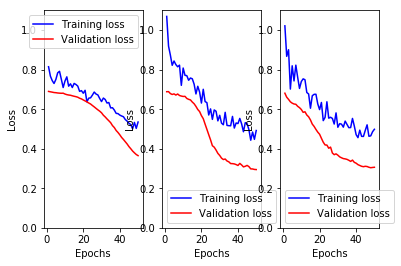

-------> adagrad <-------


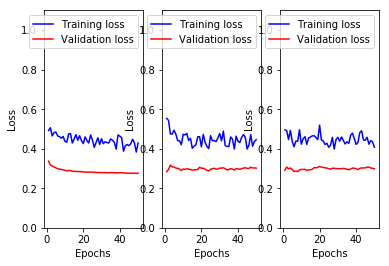

-------> adam <-------


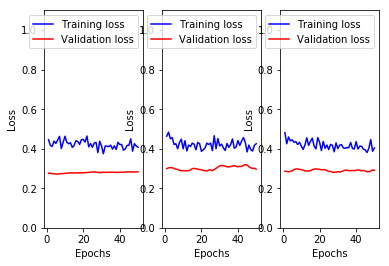

-------> adadelta <-------


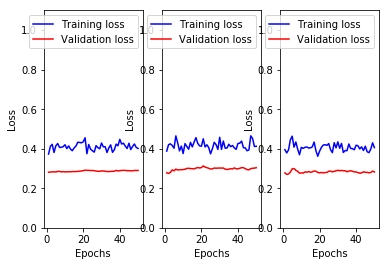

-------> nadam <-------


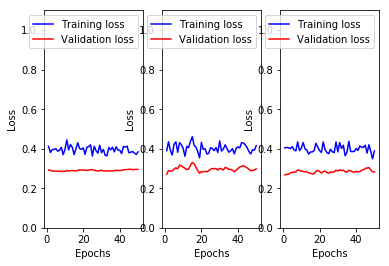

==================================== Start 2 fold ===============================
-------> rmsprop <-------


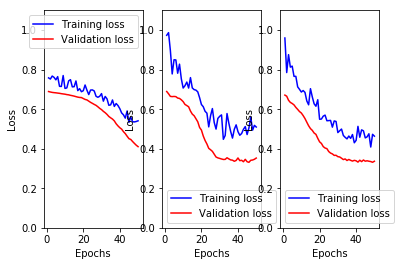

-------> adagrad <-------


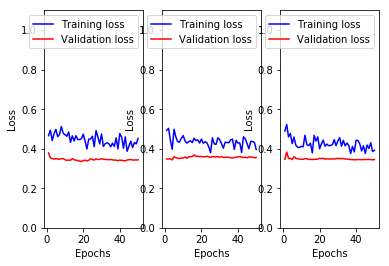

-------> adam <-------


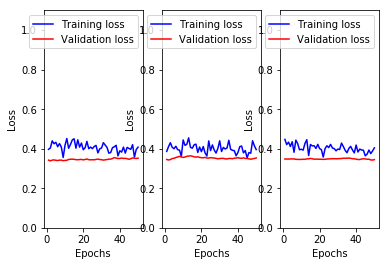

-------> adadelta <-------


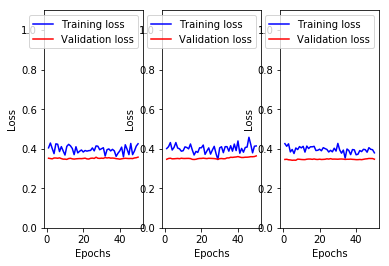

-------> nadam <-------


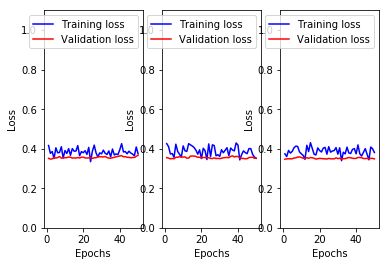

==================================== Start 3 fold ===============================
-------> rmsprop <-------


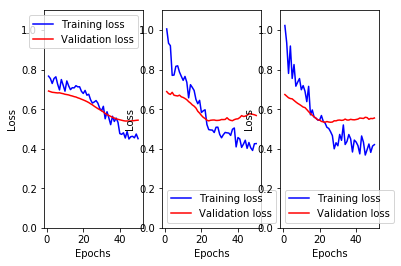

-------> adagrad <-------


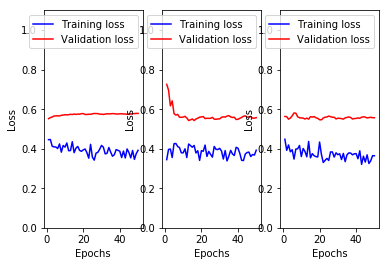

-------> adam <-------


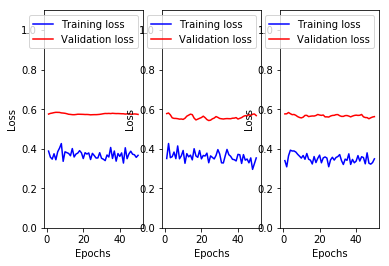

-------> adadelta <-------


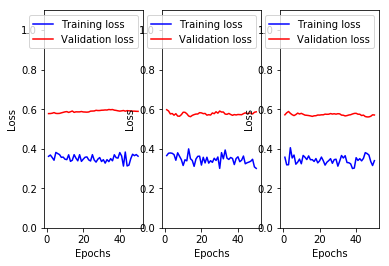

-------> nadam <-------


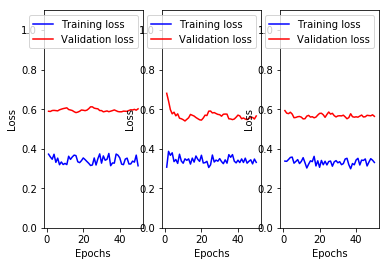

==================================== Start 4 fold ===============================
-------> rmsprop <-------


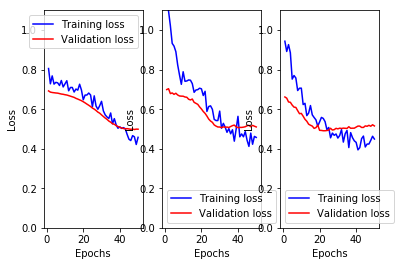

-------> adagrad <-------


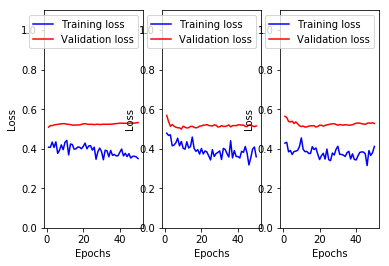

-------> adam <-------


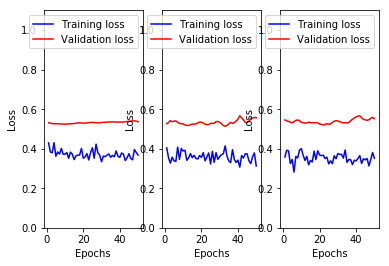

-------> adadelta <-------


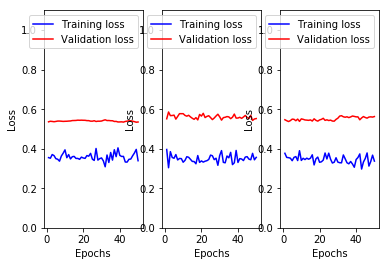

-------> nadam <-------


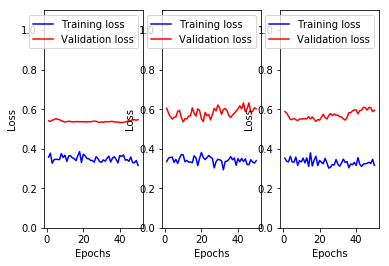

==================================== Start 5 fold ===============================
-------> rmsprop <-------


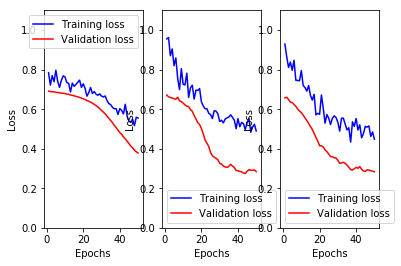

-------> adagrad <-------


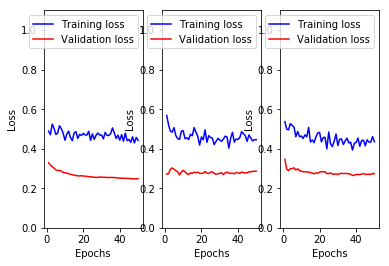

-------> adam <-------


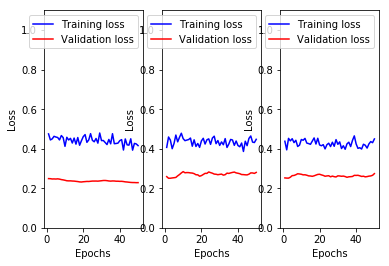

-------> adadelta <-------


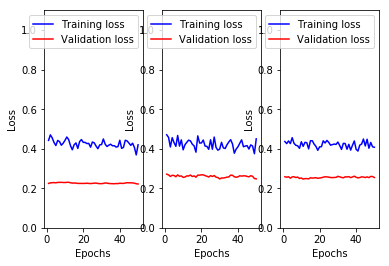

-------> nadam <-------


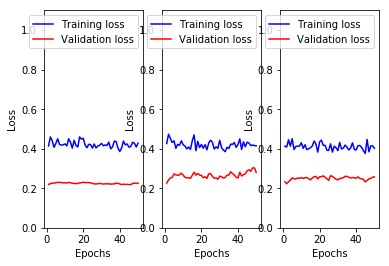

Acc : rmsprop : 1 : 83.14% (+/- 5.93%)
Acc : rmsprop : 2 : 84.48% (+/- 8.57%)
Acc : rmsprop : 3 : 83.81% (+/- 6.27%)
Acc : adagrad : 1 : 84.49% (+/- 6.42%)
Acc : adagrad : 2 : 84.15% (+/- 6.87%)
Acc : adagrad : 3 : 84.15% (+/- 5.98%)
Acc : adam : 1 : 83.82% (+/- 5.35%)
Acc : adam : 2 : 84.49% (+/- 6.15%)
Acc : adam : 3 : 83.81% (+/- 7.21%)
Acc : adadelta : 1 : 83.49% (+/- 5.32%)
Acc : adadelta : 2 : 83.82% (+/- 5.78%)
Acc : adadelta : 3 : 83.82% (+/- 5.78%)
Acc : nadam : 1 : 83.49% (+/- 5.85%)
Acc : nadam : 2 : 82.47% (+/- 6.17%)
Acc : nadam : 3 : 83.82% (+/- 6.33%)


In [25]:
seed = 10
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
optimizerList = ["rmsprop","adagrad","adam","adadelta","nadam"]
count = 0

for train, test in kfold.split(X_corr, y_corr):
    X_train_kfold_corr = X_corr.iloc[train]
    y_train_kfold_corr = y_corr.iloc[train]
    X_test_kfold_corr = X_corr.iloc[test]
    y_test_kfold_corr = y_corr.iloc[test]

    X_train_kfold_pre_corr, X_test_kfold_pre_corr = preprocess_scaler_corr(X_train_kfold_corr, X_test_kfold_corr)

    #==================================================================================
    #create model
    model1 = Sequential()
    model1.add(Dense(48, input_dim=14, activation="sigmoid"))
    model1.add(Dropout(0.5))
    model1.add(Dense(48, activation="sigmoid"))
    model1.add(Dropout(0.5))
    model1.add(Dense(48, activation="sigmoid"))
    model1.add(Dropout(0.5))
    model1.add(Dense(1, activation='sigmoid'))
    
    model2 = Sequential()
    model2.add(Dense(72, input_dim=14, activation="softplus"))
    model2.add(Dropout(0.5))
    model2.add(Dense(72, activation="softplus"))
    model2.add(Dropout(0.5))
    model2.add(Dense(72, activation="softplus"))
    model2.add(Dropout(0.5))
    model2.add(Dense(72, activation="softplus"))
    model2.add(Dropout(0.5))
    model2.add(Dense(1, activation='sigmoid'))
    
    model3 = Sequential()
    model3.add(Dense(64, input_dim=14, activation="softplus"))
    model3.add(Dropout(0.5))
    model3.add(Dense(64, activation="softplus"))
    model3.add(Dropout(0.5))
    model3.add(Dense(64, activation="softplus"))
    model3.add(Dropout(0.5))
    model3.add(Dense(1, activation='sigmoid'))
    
    modelList = [model1,model2,model3]
    hisList = []
    pltList = [131,132,133]

    print("==================================== Start "+str(count+1)+" fold ===============================")
    # Compile model
    for op in range(0,len(optimizerList)):
        hisList = []
        print("-------> "+optimizerList[op]+" <-------")
        for index in range(0,len(modelList)):
            sModel = modelList[index]
            sModel.compile(loss='binary_crossentropy', optimizer=optimizerList[op], metrics=['accuracy'])
            history = sModel.fit(X_train_kfold_pre_corr, y_train_kfold_corr,
                                    epochs=50, batch_size=32, validation_data = (X_test_kfold_pre_corr, y_test_kfold_corr),
                                   verbose=0)
            scores = sModel.evaluate(X_test_kfold_pre_corr, y_test_kfold_corr, verbose=0)
#             print("%s: %.2f%%" % (sModel.metrics_names[1], scores[1]*100))
            cvscores[index][op].append(scores[1] * 100)

            history_dict = history.history
            loss_values = history_dict['loss']
            val_loss_values = history_dict['val_loss']
            acc_values = history_dict['acc']
            val_acc_values = history_dict['val_acc']

            epochs = range(1, len(loss_values)+1)
            
            plt.figure(1)
            plt.subplot(pltList[index])
            plt.plot(epochs, loss_values, 'b', label='Training loss')
            plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.ylim([0, 1.1])
            plt.legend()
        plt.show()
    count = count + 1
    #==================================================================================

#     print(y_test_kfold.value_counts())
#     show_loss_graph(history)
for op in range(0,len(optimizerList)):
    for i in range(0,3):
        print("Acc : %s : %d : %.2f%% (+/- %.2f%%)" % (optimizerList[op], i+1, np.mean(cvscores[i][op]), np.std(cvscores[i][op])))
# print(cvscores)

## 5. Training and Validation

In [ ]:
# Visualize the training process: loss function
def show_loss_graph(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']

    epochs = range(1, len(loss_values)+1)

    plt.figure()
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim([0, 2])
    plt.legend()
    plt.show()

In [ ]:
# Training & validation accuracy

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 6. Evaluation

In [ ]:
prediction = model.predict(X_test)
prediction = (prediction > 0.5)

In [ ]:
cm = confusion_matrix(y_test, prediction, labels=[0, 1])
print(cm)

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=128)
print("score: ",score)
print()
target_names = ["Healthy","Heart Desease"]
print(classification_report(y_test,prediction, target_names=target_names))

## 7. Results and Discussion

In [ ]:
# Maybe some graphics?

## 8. Conclusions